In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

In [2]:
# NOTE (05/11/2022) - The default URL for downloading the dataset via TFDS is currently invalid. This piece of code
# will patch that URL with the correct one. Please run this before importing the packages. If it fails, kindly report
# in our Discourse community. Thank you!

DATASET_PATH = '/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py'
!sed -i 's/3367a/5340/g' {DATASET_PATH}

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

**Helper Function**

In [9]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()

def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

**Load dataset**

In [4]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteF1AVY1/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
def augment_images(image, label):
  
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

**Build Classifier**

In [ ]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()

In [7]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(lr=0.001))
model.fit(train_batches,epochs=25)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/25
582/582 [==============================] - 70s 106ms/step - loss: 0.6630 - accuracy: 0.5909
Epoch 2/25
582/582 [==============================] - 67s 112ms/step - loss: 0.6252 - accuracy: 0.6517
Epoch 3/25
582/582 [==============================] - 67s 113ms/step - loss: 0.6012 - accuracy: 0.6811
Epoch 4/25
582/582 [==============================] - 64s 107ms/step - loss: 0.5817 - accuracy: 0.6975
Epoch 5/25
582/582 [==============================] - 66s 111ms/step - loss: 0.5704 - accuracy: 0.7097
Epoch 6/25
582/582 [==============================] - 69s 115ms/step - loss: 0.5550 - accuracy: 0.7256
Epoch 7/25
582/582 [==============================] - 64s 107ms/step - loss: 0.5453 - accuracy: 0.7325
Epoch 8/25
582/582 [==============================] - 63s 105ms/step - loss: 0.5340 - accuracy: 0.7379
Epoch 9/25
582/582 [==============================] - 62s 104ms/step - loss: 0.5260 - accuracy: 0.7443
Epoch 10/25
582/582 [==============================] - 63s 104ms/step - l

**Build CAM model**

In [8]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496 

**Testing Model**

In [10]:
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

--2022-09-19 14:15:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.111.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.003s  

2022-09-19 14:15:48 (152 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2022-09-19 14:15:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.111.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to: ‘cat2.jpg’



sigmoid output: [[0.2772981]]
prediction: cat


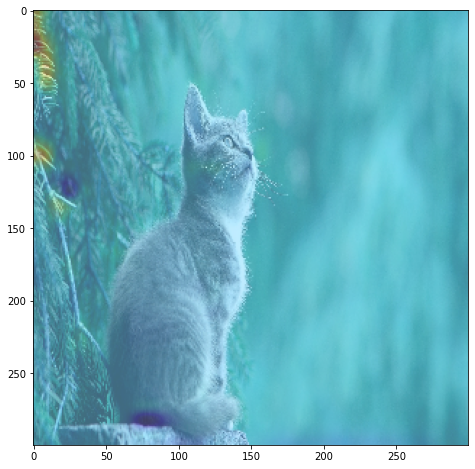

sigmoid output: [[0.12809059]]
prediction: cat


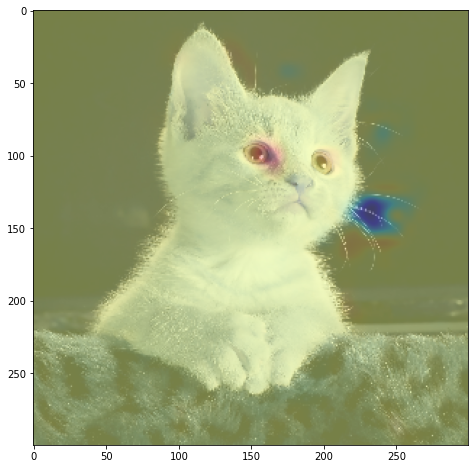

sigmoid output: [[0.4083261]]
prediction: cat


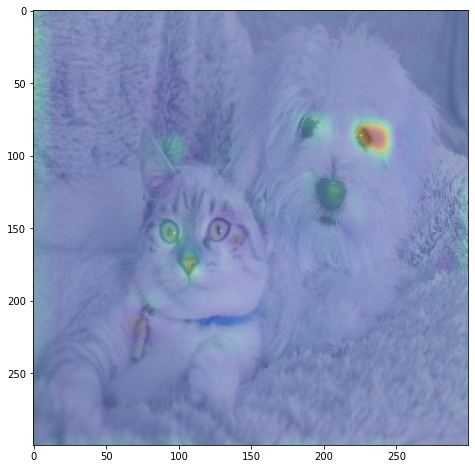

sigmoid output: [[0.20599954]]
prediction: cat


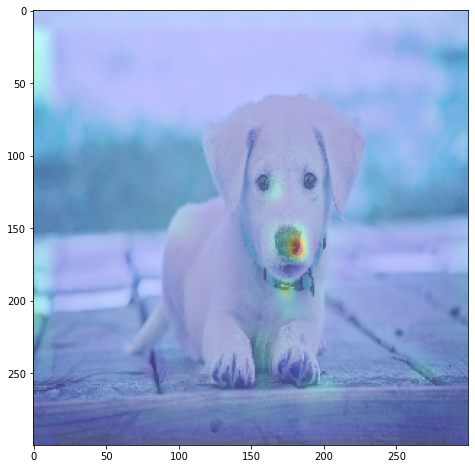

sigmoid output: [[0.5112598]]
prediction: dog


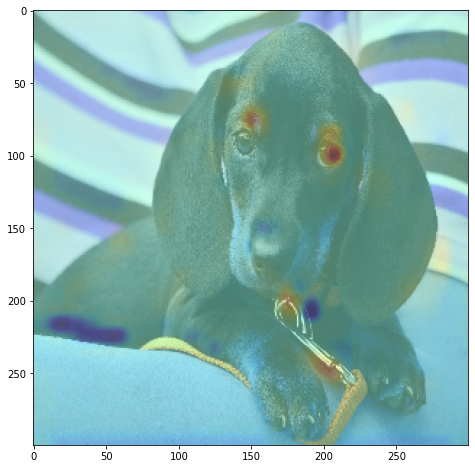

In [11]:
convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
sigmoid output: [[0.41732058]]
prediction: cat


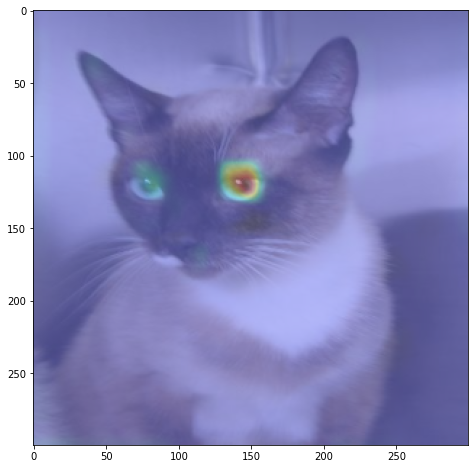

ground truth: dog
sigmoid output: [[0.1632315]]
prediction: cat


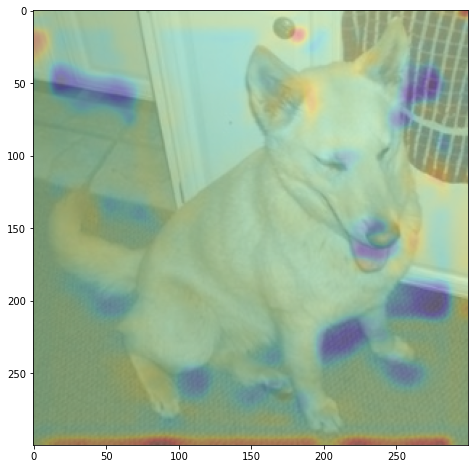

ground truth: dog
sigmoid output: [[0.5593504]]
prediction: dog


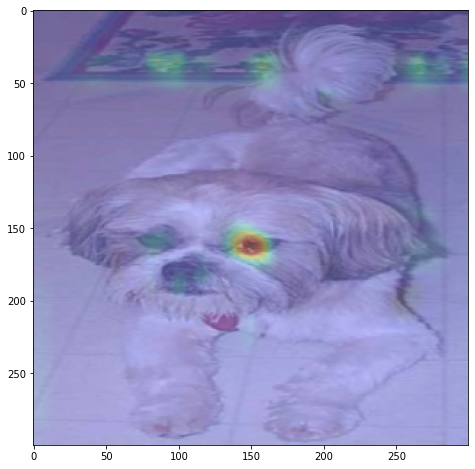

ground truth: cat
sigmoid output: [[0.05683377]]
prediction: cat


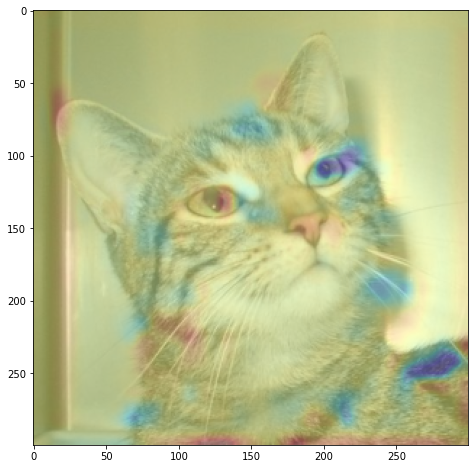

ground truth: cat
sigmoid output: [[0.17231981]]
prediction: cat


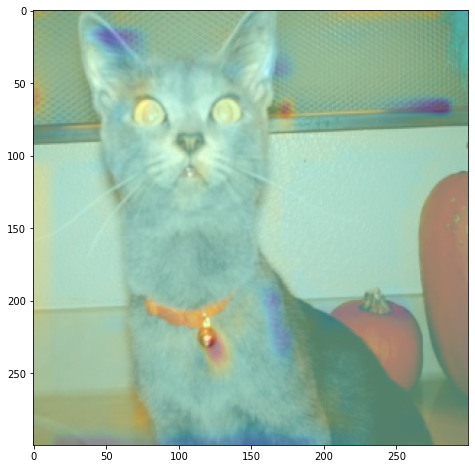

In [12]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)